# Bank loan model : The big picture


This case is about a bank (**Thera Bank**) which has a growing customer base.


Majority of these customers are **liability customers** (depositors) with varying size of deposits. The number of customers who are also borrowers (asset customers) is quite small, and **the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans**. 


In particular, the management wants to **explore ways of converting its liability customers to personal loan customers (while retaining them as depositors)**. 


A campaign that the bank ran last year for liability customers showed **a healthy conversion rate of over 9% success**. 


This has encouraged the retail marketing department to devise campaigns to better target marketing to increase the success ratio with a minimal budget.




## Framing the problem


### What is the business objective ?


The department wants to build a model that will **help them identify the potential customers who have a higher probability of purchasing the loan**. 

**This will increase the success ratio while at the same time reduce the cost of the campaign**.



### What is the type of learning ?



With the gathered information, we are ready to design our system.<br>

- This is a **supervised learning task** because the model can train on labeled examples (customers who actually purchased a loan). <br>


- It’s a **classification task** since the goal is to predict the likelihood of customers to purchase a loan or not. <br>



## Selecting a performance measure


The next step is to choose a performance measure. <br>

For our case, the main metric to use is the **recall** :   $$recall  = \frac{TP}{TP + FN}$$<br>
with **TP** : True Positives and **FN** : False Negatives



In machine learning, recall is a performance metric that measures the ability of a classification model to correctly identify all relevant instances of the positive class. <br>

It is particularly important in situations **where missing positive cases (false negatives) is more critical than incorrectly classifying negatives as positives**. <br>

In other words, we are interested in **detecting most of the customers that would purchase a loan** and **we accept a higher number of False Positive** detection.




Additionally, we will calculate : <br>
- the precision :  $$precision  = \frac{TP}{TP + FP}$$ <br>

- the F1 score :    $$F_1  = \frac{2}{\frac{1}{precision}+ \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP +  \frac{FN + FP}{2}} $$ <br><br>


with **TP** : True Positives and **FN** : False Negatives


In machine learning, **precision** is a metric used to evaluate the performance of a classification model, especially in cases where the classes are imbalanced or when the cost of false positives is high.<br>
Precision focuses on the proportion of correctly identified positive instances out of all instances that were predicted as positive.

The **F1 score** is a performance metric used in machine learning to evaluate the accuracy of a classification model, especially when dealing with imbalanced datasets. <br>
It is the harmonic mean of precision and recall, providing a single score that balances the trade-off between them.


# Getting the data


## Import libraries


Here will be imported all the necessary libraries that we'll use for this task !

In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

# General libraries
import pandas as pd
import math

# Visualization
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

# Split train set and test set
from sklearn.model_selection import train_test_split

# Geolocation libraries
import pgeocode 
from geopy.geocoders import Nominatim


## Import the data


We import the data and store it locally.

In [2]:
# Retrieve the data stored locally
path = "../data/raw_data"
banking_data = pd.read_excel(path + "/Bank_Personal_Loan_Modelling.xlsx", sheet_name="Data")

banking_data.head()

ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

## Describe the features


We have the following features : <br>
**ID**: Customer ID<br>
**Age**: Customer's age in completed years<br>
**Experience**: #years of professional experience<br>
**Income**: Annual income of the customer (**in thousands of dollars**) <br>
**ZIP_Code**: Home Address ZIP code.<br>
**Family**: Family size of the customer <br>
**CCAvg**: Avg. spending on credit cards per month (**in thousands of dollars**)<br>
**Education**: Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional<br>
**Mortgage**: Value of house mortgage if any (**in thousands of dollars**).<br>
**Personal Loan**: Did this customer accept the personal loan offered in the last campaign?<br>
**Securities Account**: Does the customer have a securities account with the bank?<br>
**CD Account**: Does the customer have a certificate of deposit (CD) account with the bank?<br>
**Online**: Does the customer use internet banking facilities?<br>
**CreditCard**: Does the customer use a credit card issued by UniversalBank?<br>



## Rewrite feature names


Updating the feature names for easier use.


In [3]:
# Updating the feature names for easier use.
banking_data = banking_data.rename(columns={
                                            "ZIP Code":"ZIP_Code", 
                                            "Personal Loan":"Personal_Loan",
                                            "Securities Account":"Securities_Account",
                                            "CD Account": "CD_Account"
                                            })

banking_data.head(2)

ID  Age  Experience  Income  ZIP_Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   

   Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0

## Dropping features


We won't need the ID column. Let's drop it !


In [4]:
# We won't need the ID column. Let's drop it !
banking_data = banking_data.drop(columns=['ID'])
banking_data.head(2)

Age  Experience  Income  ZIP_Code  Family  CCAvg  Education  Mortgage  \
0   25           1      49     91107       4    1.6          1         0   
1   45          19      34     90089       3    1.5          1         0   

   Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0

## Creating longitude and latitude feature from ZIP code


In [5]:
# Retrieve geographical info from zip code
ZIP_Codes = banking_data['ZIP_Code'].values.astype('str').tolist()
nomi = pgeocode.Nominatim('us')
df_PostalCode = nomi.query_postal_code(ZIP_Codes)
df_PostalCode['postal_code'] = df_PostalCode['postal_code'].values.astype('int64')
df_PostalCode.head(3)


postal_code country_code   place_name  state_name state_code  county_name  \
0        91107           US     Pasadena  California         CA  Los Angeles   
1        90089           US  Los Angeles  California         CA  Los Angeles   
2        94720           US     Berkeley  California         CA      Alameda   

   county_code community_name  community_code  latitude  longitude  accuracy  
0         37.0            NaN             NaN   34.1510  -118.0889       4.0  
1         37.0            NaN             NaN   33.7866  -118.2987       4.0  
2          1.0            NaN             NaN   37.8738  -122.2549       4.0

In [6]:
# Create latitude and longitude columns
banking_data = pd.merge(banking_data,df_PostalCode[['postal_code', 'latitude', 'longitude']],
                        how='inner',
                        left_on='ZIP_Code',
                        right_on='postal_code')

# Dropping postal_code (not needed anymore)
banking_data = banking_data.drop(columns='postal_code')

# Check
banking_data.head()

Age  Experience  Income  ZIP_Code  Family  CCAvg  Education  Mortgage  \
0   25           1      49     91107       4    1.6          1         0   
1   25           1      49     91107       4    1.6          1         0   
2   25           1      49     91107       4    1.6          1         0   
3   25           1      49     91107       4    1.6          1         0   
4   25           1      49     91107       4    1.6          1         0   

   Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  \
0              0                   1           0       0           0   
1              0                   1           0       0           0   
2              0                   1           0       0           0   
3              0                   1           0       0           0   
4              0                   1           0       0           0   

   latitude  longitude  
0    34.151  -118.0889  
1    34.151  -118.0889  
2    34.151  -118.0889  
3    34.151  -118.0889  
4    34.151  -118.0889

# Exploring the data


## Quick exploration

In [7]:
# summary of the DataFrame
banking_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149918 entries, 0 to 149917
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Age                 149918 non-null  int64  
 1   Experience          149918 non-null  int64  
 2   Income              149918 non-null  int64  
 3   ZIP_Code            149918 non-null  int64  
 4   Family              149918 non-null  int64  
 5   CCAvg               149918 non-null  float64
 6   Education           149918 non-null  int64  
 7   Mortgage            149918 non-null  int64  
 8   Personal_Loan       149918 non-null  int64  
 9   Securities_Account  149918 non-null  int64  
 10  CD_Account          149918 non-null  int64  
 11  Online              149918 non-null  int64  
 12  CreditCard          149918 non-null  int64  
 13  latitude            149323 non-null  float64
 14  longitude           149323 non-null  float64
dtypes: float64(3), int64(12)
memory us

In [8]:
# Descriptive statistics
banking_data.describe()

Age     Experience         Income       ZIP_Code  \
count  149918.000000  149918.000000  149918.000000  149918.000000   
mean       45.097627      19.861338      73.215798   93553.716585   
std        11.554059      11.565649      45.894499    1735.784169   
min        23.000000      -3.000000       8.000000    9307.000000   
25%        35.000000      10.000000      38.000000   92110.000000   
50%        45.000000      20.000000      64.000000   94305.000000   
75%        55.000000      30.000000      98.000000   94720.000000   
max        67.000000      43.000000     224.000000   96651.000000   

              Family          CCAvg      Education       Mortgage  \
count  149918.000000  149918.000000  149918.000000  149918.000000   
mean        2.431376       1.896169       1.896877      55.524720   
std         1.156294       1.692479       0.836324      99.840732   
min         1.000000       0.000000       1.000000       0.000000   
25%         1.000000       0.700000       1.000000       0.000000   
50%         2.000000       1.500000       2.000000       0.000000   
75%         4.000000       2.500000       3.000000     101.000000   
max         4.000000      10.000000       3.000000     635.000000   

       Personal_Loan  Securities_Account     CD_Account         Online  \
count  149918.000000       149918.000000  149918.000000  149918.000000   
mean        0.096920            0.105004       0.064482       0.590103   
std         0.295849            0.306560       0.245610       0.491816   
min         0.000000            0.000000       0.000000       0.000000   
25%         0.000000            0.000000       0.000000       0.000000   
50%         0.000000            0.000000       0.000000       1.000000   
75%         0.000000            0.000000       0.000000       1.000000   
max         1.000000            1.000000       1.000000       1.000000   

          CreditCard       latitude      longitude  
count  149918.000000  149323.000000  149323.000000  
mean        0.292113      36.339455    -120.659033  
std         0.454736       2.014888       1.982263  
min         0.000000      32.562600    -124.159300  
25%         0.000000      34.109200    -122.254900  
50%         0.000000      37.423600    -121.867300  
75%         1.000000      37.873800    -118.411900  
max         1.000000      41.724300    -115.573000

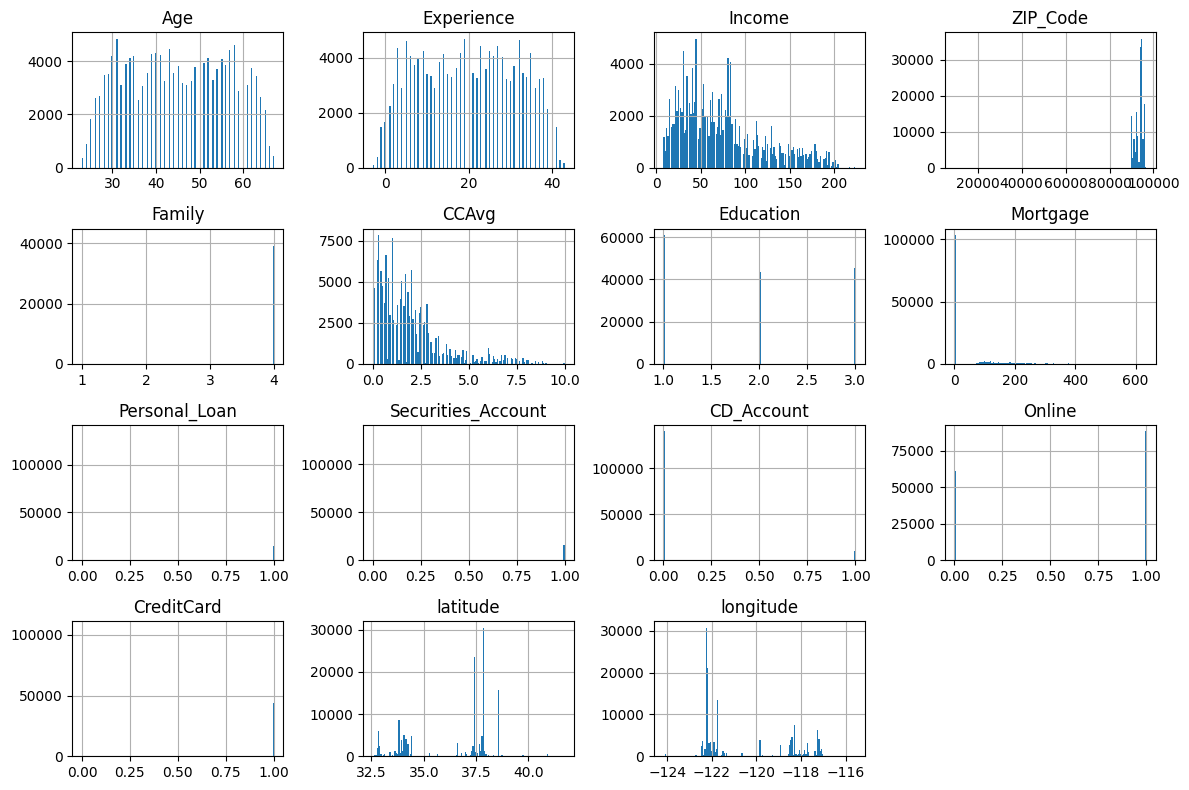

In [9]:
# Histogram of the DataFrame’s columns
banking_data.hist(bins=150, figsize=(12, 8))
plt.tight_layout()
plt.show()

## Test set and train set

### Check target balance


Our target is **Personal_Loan**. <br> 
Let's check the balance of the target.


In [10]:
# Our target is Personal_Loan. Let's check the balance of the target.
banking_data.Personal_Loan.value_counts()/len(banking_data)*100

0    90.308035
1     9.691965
Name: Personal_Loan, dtype: float64

Less than 10% of customers accepted the personal loan offered in the last campaign. <br>
We'll need to stratify the test set and the train set to have the same proportions of labels. 


### Train set and test set: Stratification



We split the data in : <br>
- a train on which we will train our final model
- a test set we will use to evaluate the model (in the end)

In [11]:
# Create train set and test set (stratified based on median incom categories)
strat_train_set, strat_test_set = train_test_split(
    banking_data, test_size=0.2, stratify=banking_data["Personal_Loan"], random_state=42)

In [12]:
# Check of stratified train set
strat_train_set.Personal_Loan.value_counts()/len(strat_train_set)*100

0    90.308003
1     9.691997
Name: Personal_Loan, dtype: float64

In [13]:
# Check of stratified test set
strat_test_set.Personal_Loan.value_counts()/len(strat_test_set)*100

0    90.308164
1     9.691836
Name: Personal_Loan, dtype: float64

## Explore and visualizing the data to gain insights


In [14]:
# Create a copy of the stratified train set before exploring
bank = strat_train_set.copy()

Let's look at the type of the features !


In [15]:
# Type of features 
continuous_feats = ['CCAvg','latitude','longitude']
discrete_feats = ['Age', 'Experience', 'Income', 'ZIP_Code','Mortgage']
categorical_feats = ['Education','Personal_Loan', 'Family']
binary_feats = ['Securities_Account','CD_Account','Online','CreditCard']

### Univariate analysis


#### Numerical features



In [16]:
# Numerical features
numerical_feats = continuous_feats + discrete_feats
numerical_feats

['CCAvg',
 'latitude',
 'longitude',
 'Age',
 'Experience',
 'Income',
 'ZIP_Code',
 'Mortgage']

In [17]:
bank.head()

Age  Experience  Income  ZIP_Code  Family  CCAvg  Education  Mortgage  \
15094    53          27     192     94720       1    1.7          1       601   
115277   39          13      43     94304       3    0.5          3         0   
96067    33           6      78     95819       4    2.0          2         0   
146986   39          13      74     95008       3    0.9          2       155   
133705   65          39      20     90034       3    0.7          2         0   

        Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  \
15094               0                   0           0       1           0   
115277              0                   0           0       1           0   
96067               0                   1           0       1           0   
146986              0                   0           0       1           0   
133705              0                   0           0       0           1   

        latitude  longitude  
15094    37.8738  -122.2549  
115277   37.4334  -122.1842  
96067    38.5683  -121.4366  
146986   37.2803  -121.9539  
133705   34.0290  -118.4005

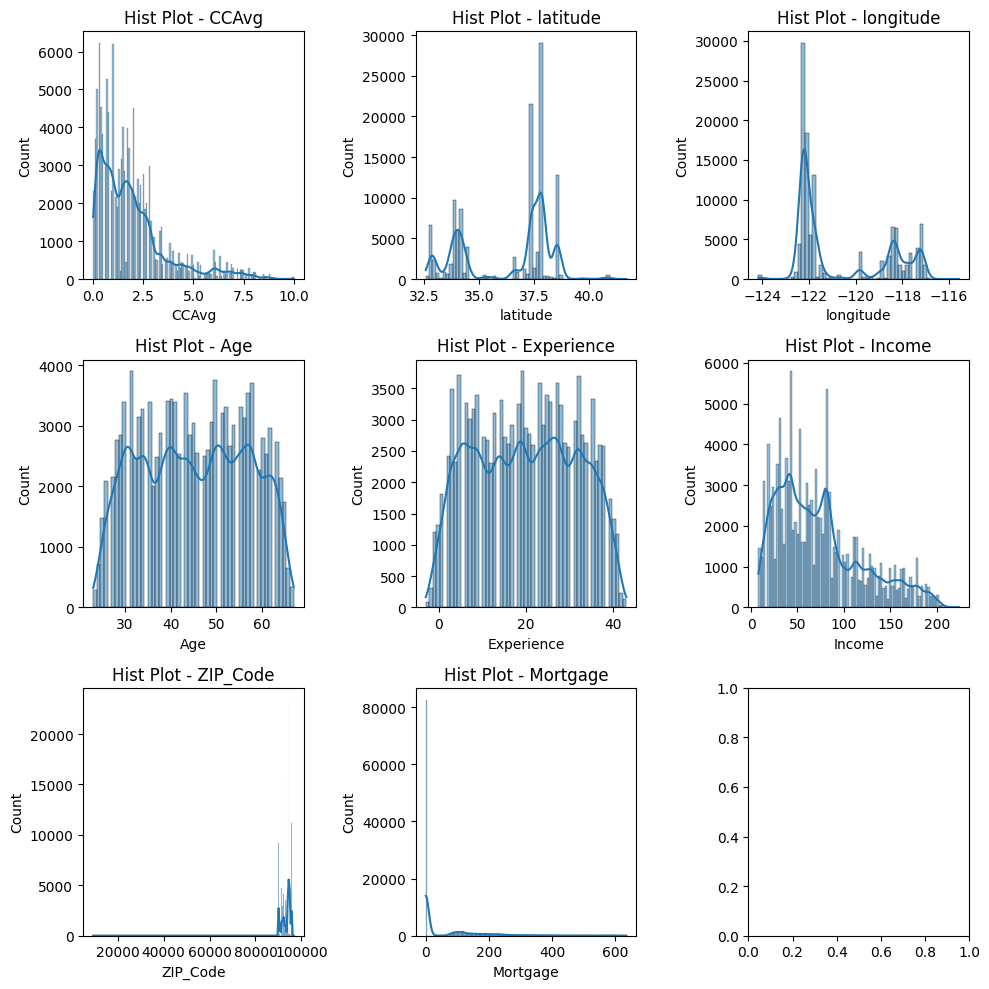

In [18]:
# Plot histograms
ncol_max = 3
nrow_max = round(len(bank[numerical_feats].columns)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))


# Flatten axes for easy iteration
axs = axs.flatten()

# Histograms
for col in bank[numerical_feats].columns:  
        # Plotting the histograms
        sns.histplot(data = bank[numerical_feats], 
                     x= bank[col], 
                     kde = True,                                   
                     ax=axs[bank[numerical_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[numerical_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[numerical_feats].columns.get_loc(col)].set_title(f'Hist Plot - {col}')  

# Adjust layout
plt.tight_layout()
plt.show()

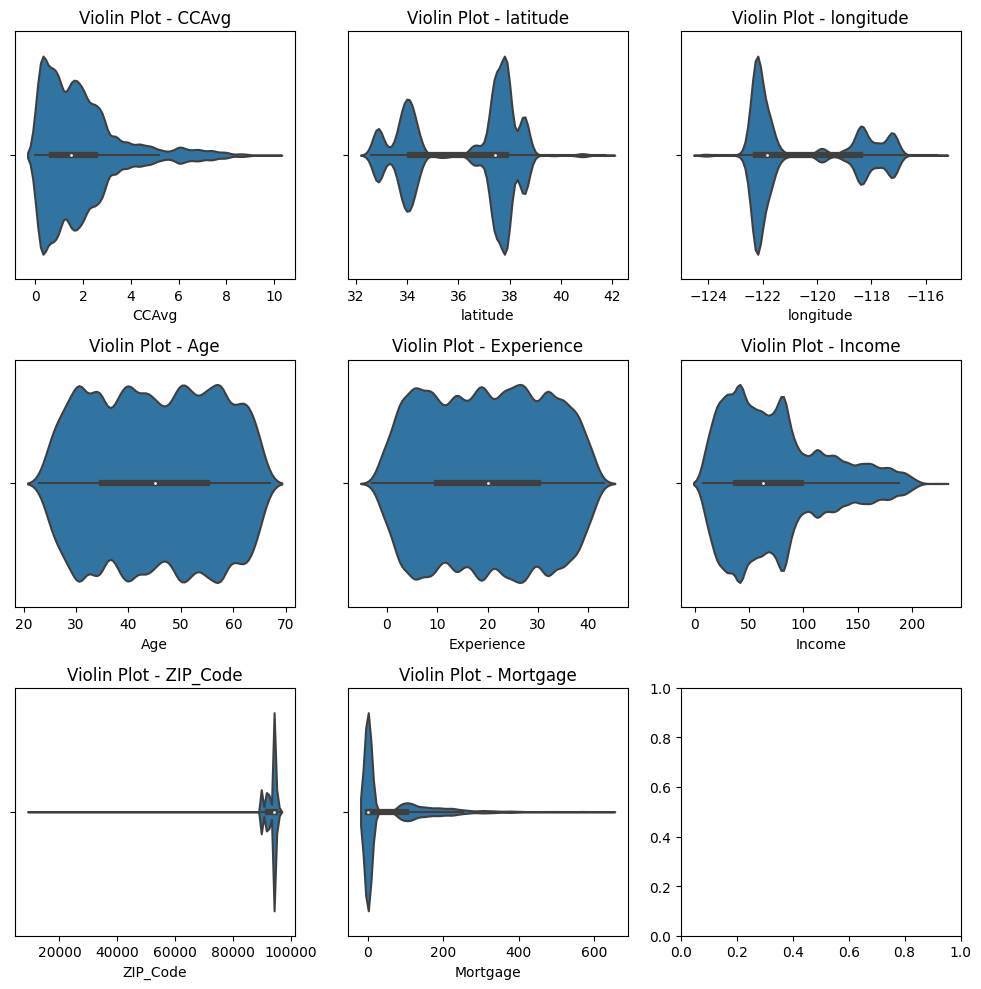

In [19]:
# Plot violin plots
ncol_max = 3
nrow_max = round(len(bank[numerical_feats].columns)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))


# Flatten axes for easy iteration
axs = axs.flatten()

# boxplots
for col in bank[numerical_feats].columns:  
        # Plotting the violin plots
        sns.violinplot(data = bank[numerical_feats], 
                     x= bank[col],                                   
                     ax=axs[bank[numerical_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[numerical_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[numerical_feats].columns.get_loc(col)].set_title(f'Violin Plot - {col}')  

# Adjust layout
plt.tight_layout()
plt.show()


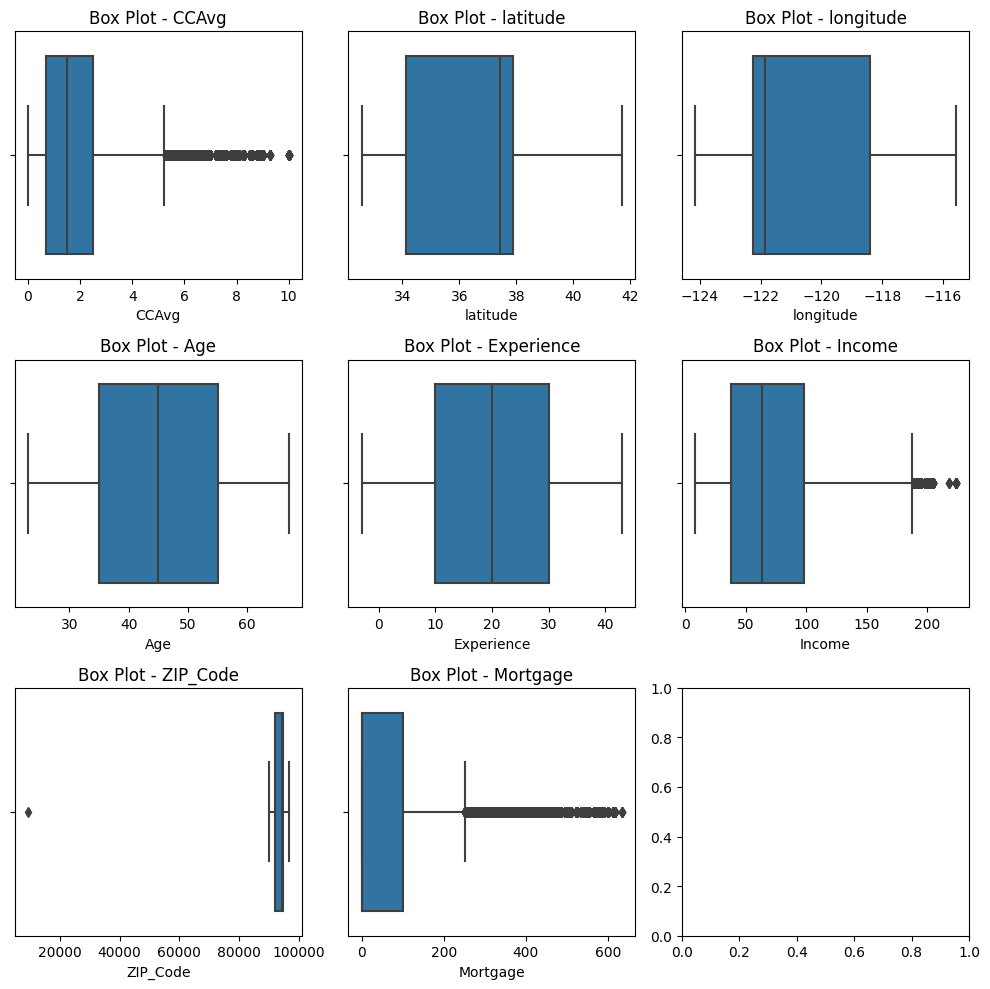

In [20]:
# Plot boxplots
ncol_max = 3
nrow_max = round(len(bank[numerical_feats].columns)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))


# Flatten axes for easy iteration
axs = axs.flatten()

# boxplots
for col in bank[numerical_feats].columns:  
        # Plotting the boxplots
        sns.boxplot(data = bank[numerical_feats], 
                     x= bank[col],                                   
                     ax=axs[bank[numerical_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[numerical_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[numerical_feats].columns.get_loc(col)].set_title(f'Box Plot - {col}')  

# Adjust layout
plt.tight_layout()
plt.show()



**Insights** :

- CCAvg : The median spending on credit card per month is **around 1500 USD**.
- Age : The median age is **around 45 years old**.
- Experience : The median number of years of professional experience is **around 20 years**.
- Income : The median income is around **70 000 USD**.


#### Categorical features



In [21]:
# Categorical features
categorical_feats = ['Education','Personal_Loan', 'Family']
binary_feats = ['Securities_Account','CD_Account','Online','CreditCard']

categories_feats = categorical_feats + binary_feats
categories_feats


['Education',
 'Personal_Loan',
 'Family',
 'Securities_Account',
 'CD_Account',
 'Online',
 'CreditCard']

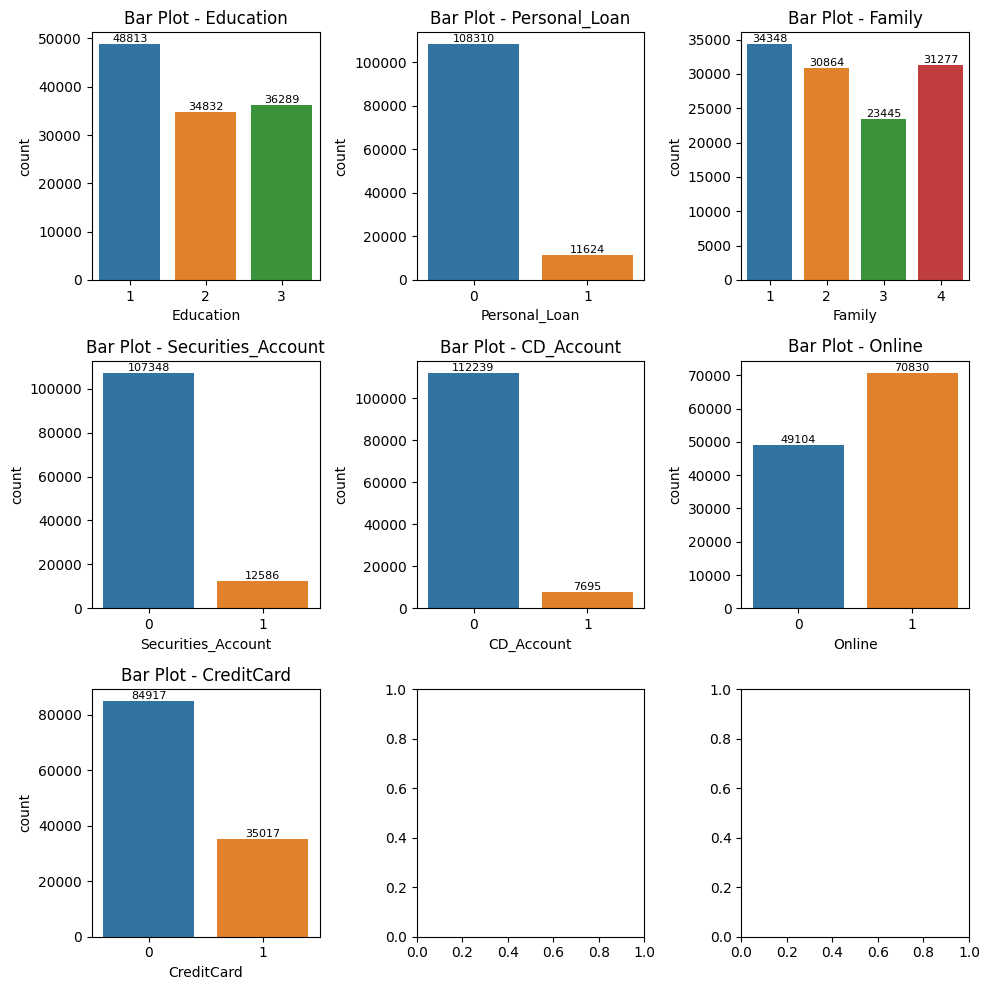

In [22]:
# Plot count plots
ncol_max = 3
nrow_max = math.ceil(len(bank[categories_feats].columns)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))

# Flatten axes for easy iteration
axs = axs.flatten()

# boxplots
for col in bank[categories_feats].columns:  
        # Plotting the count plots
        sns.countplot(data = bank[categories_feats], 
                     x= bank[col],                                   
                     ax=axs[bank[categories_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[categories_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[categories_feats].columns.get_loc(col)].set_title(f'Bar Plot - {col}')  
        axs[bank[categories_feats].columns.get_loc(col)].bar_label(            
            axs[bank[categories_feats].columns.get_loc(col)].containers[0],
            fontsize=8
            )                        

            
# Adjust layout
plt.tight_layout()
plt.show()

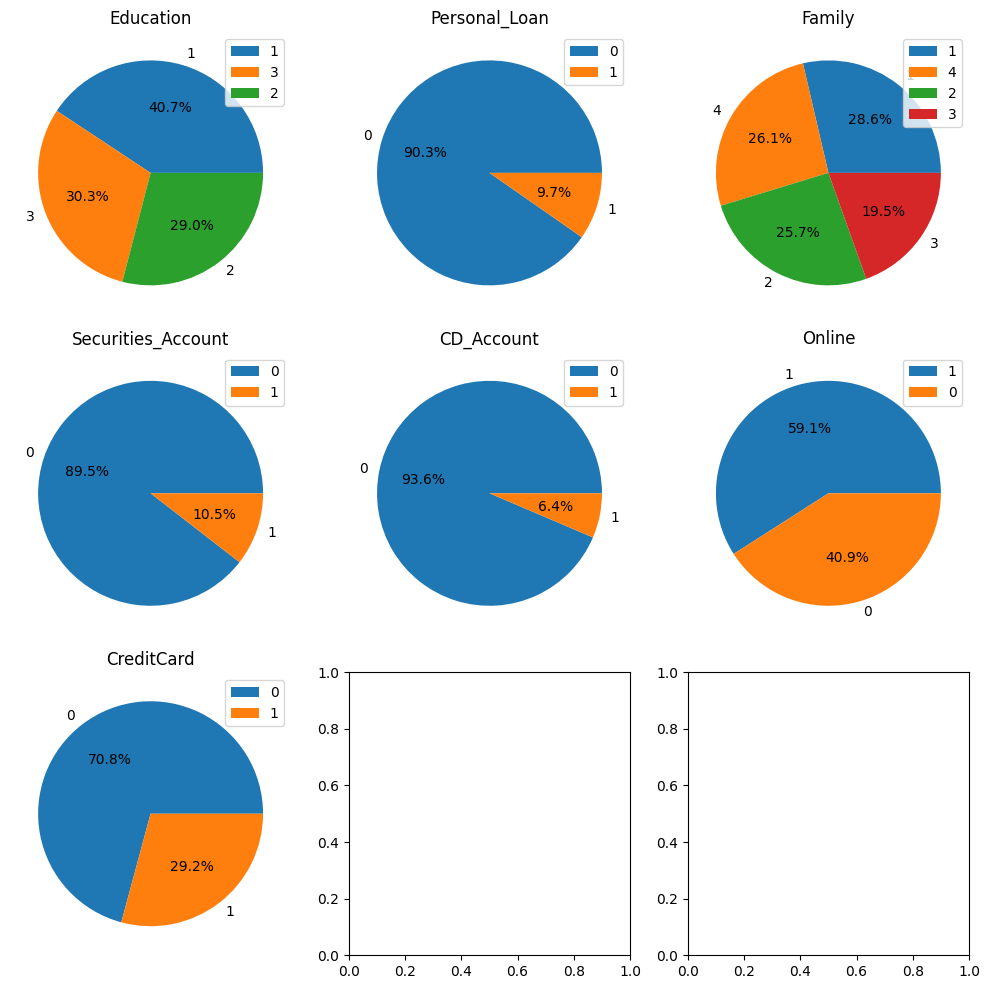

In [23]:
# Plot pie charts
ncol_max = 3
nrow_max = math.ceil(len(bank[categories_feats].columns)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))

# Flatten axes for easy iteration
axs = axs.flatten()

# boxplots
for col in bank[categories_feats].columns:  
        # Example DataFrame
        data = pd.DataFrame({'Category': bank[col].value_counts().index.values, 
                             'Values': bank[col].value_counts().values})

        # Create a pie chart
        data.set_index('Category').plot.pie(y='Values',
                                            autopct='%1.1f%%', 
                                            ax = axs[bank[categories_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[categories_feats].columns.get_loc(col)].set_title(f'{col}') 
        axs[bank[categories_feats].columns.get_loc(col)].set_ylabel('')              

            
# Adjust layout
plt.tight_layout()
plt.show()


### Visualizing Geographical data


In [24]:
# # Geographical scatter plot of the data
# bank.plot(kind="scatter",
#           x="longitude", 
#           y="latitude", 
#           grid=True,cmap="jet",
#           colorbar=True,
#           legend=True, 
#           sharex=False, 
#           figsize=(10, 7))
# plt.show()

In [25]:
# # Geographical scatter plot of the data
# bank.plot(kind="scatter",
#           x="longitude",
#           y="latitude",
#           grid=True,
#           cmap="jet",
#           s=bank["Personal_Loan"],
#           c="Income",
#           label="Personal_Loan",          
#           colorbar=True,
#           legend=True,
#           sharex=False,
#           figsize=(10, 7))
# plt.show()